# Implementación de DenseNet para una vista (CC/MLO)

Ajustamos el notebook según estemos trabajando en local o en un entorno de Google Colab. Además, seleccionamos la vista sobre la que queremos entrenar la red.

In [1]:
google_colab = 0
vista = 'CC' ## 'CC' ó 'MLO'

##  Carga y preparación de los dataset

In [2]:
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import numpy as np
if google_colab:
    from google.colab import drive
    !pip install pickle5
    import pickle5 as pickle
    drive.mount('/content/gdrive')

Definimos una función auxiliar para ayudar con el preprocesamiento de los datos (ajuste de entrada para la DenseNet en el caso de las imágenes y conversión a one-hot encoding para las etiquetas).

In [3]:
def preprocess_data(X, Y):
    """Pre-processes the data for the model
        - X is a numpy.ndarray of shape (m, 1024, 1024, 3) containing
         the mammography, where m is the number of data points
        - Y is a numpy.ndarray of shape (m,) containing
         the Bi-Rads labels for X
        Returns: X_p, Y_p
        - X_p is a numpy.ndarray containing the preprocessed X
        - Y_p is a numpy.ndarray containing the preprocessed Y
    """
    X_p = K.applications.densenet.preprocess_input(X)

    Y_p = K.utils.to_categorical(Y, 3)

    return X_p, Y_p

Cargamos los ficheros de entrada, eligiendo únicamente la vista seleccionada, tanto en el conjunto de entrenamiento-test como en el de validación.

In [4]:
if google_colab:
    with open('/content/gdrive/MyDrive/Colab Notebooks/df_INbreast_train.pkl', 'rb') as pickle_file:
        df_INbreast_train = pickle.load(pickle_file)
    with open('/content/gdrive/MyDrive/Colab Notebooks/df_INbreast_val.pkl', 'rb') as pickle_file:
        df_INbreast_val = pickle.load(pickle_file)
else:
    df_INbreast_train = pd.read_pickle('./df_INbreast_train.pkl')
    df_INbreast_val = pd.read_pickle('./df_INbreast_val.pkl')
    
if vista == 'CC':
    df_INbreast_train = df_INbreast_train.drop(columns = ['MLO Image']).rename(columns = {'CC Image': 'Image'})
    df_INbreast_val = df_INbreast_val.drop(columns = ['MLO Image']).rename(columns = {'CC Image': 'Image'})
elif vista == 'MLO':
    df_INbreast_train = df_INbreast_train.drop(columns = ['CC Image']).rename(columns = {'MLO Image': 'Image'})
    df_INbreast_val = df_INbreast_val.drop(columns = ['CC Image']).rename(columns = {'MLO Image': 'Image'})

Cargamos los datos, convertimos las etiquetas a enteros y liberamos espacio de los ficheros que contenían el dataset.

In [5]:
dict_valores = {'benigno': 0, 'control': 1, 'maligno': 2}
Y_traintest = np.array(df_INbreast_train['Bi-Rads'].map(dict_valores).tolist())
X_traintest = np.array(df_INbreast_train['Image'].tolist())
Y_val = np.array(df_INbreast_val['Bi-Rads'].map(dict_valores).tolist())
X_val = np.array(df_INbreast_val['Image'].tolist())
X_val, Y_val = preprocess_data(X_val, Y_val)
del df_INbreast_train
del df_INbreast_val

## Definición de la arquitectura de red neuronal

Definimos la arquitectura de la red neuronal, así como el inicializador y el optimizador que se usarán durante el proceso de entrenamiento. Definimos la capa de entrada de la red, en la cual las imágenes se reescalarán al tamaño definido por la arquitectura DenseNet (256p x 256p).

In [6]:
def DenseNet_1Rama(input_dim = 512, rand_seed = 2021, learning_rate = 0.0001, momentum = 0.9):
    # Define the model architecture
    densenet = K.applications.DenseNet121(
        include_top = False,
        weights = "imagenet",
        input_tensor = None,
        input_shape = (256, 256, 3),
        pooling = 'avg'
    )

    densenet.trainable = True

    for layer in densenet.layers:
        if 'conv5' in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False

    input_img = K.Input(shape = (input_dim, input_dim, 3))
    preprocess = K.layers.Lambda(lambda x: tf.image.resize(x, (256, 256)), name = 'resize')(input_img)

    initializer = K.initializers.he_normal(seed = rand_seed)
    
    fc_layer = densenet(inputs = preprocess)

    fc_layer = K.layers.Dense(units = 3,
                              activation = 'softmax',
                              kernel_initializer = initializer
                              )(fc_layer)

    model_1rama = K.models.Model(inputs = input_img, outputs = fc_layer)

    # Compile the model
    opt = K.optimizers.SGD(learning_rate = learning_rate, momentum = momentum)
    
    model_1rama.compile(loss = 'categorical_crossentropy',
                        optimizer = opt,
                        metrics = ['accuracy'])
    
    return model_1rama

Mostramos por pantalla la arquitectura de la red definida.

In [7]:
DenseNet_1Rama().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
resize (Lambda)              (None, 256, 256, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 2,161,155
Non-trainable params: 4,879,424
_________________________________________________________________


## Entrenamiento de la red neuronal

Definimos una función auxiliar que particiona el conjunto de entrenamiento/test en los dos subconjuntos correspondientes (entrenamiento y test).

In [8]:
def part_traintest(X_traintest, Y_traintest, rand_seed = 2021, frac_test = .2/.8):
    np.random.seed(rand_seed)
    index_test = np.array([], dtype = 'int64')
    for i in np.unique(Y_traintest):
        index_test = np.append(index_test, 
                               np.random.choice(list(np.where(Y_traintest == i)[0]), size = int(np.where(Y_traintest == i)[0].shape[0]*frac_test), replace = False))
    X_train = np.delete(X_traintest, index_test, axis = 0)
    Y_train = np.delete(Y_traintest, index_test)
    X_test = np.take(X_traintest, index_test, axis = 0)
    Y_test = np.take(Y_traintest, index_test)
    X_train, Y_train = preprocess_data(X_train, Y_train)
    X_test, Y_test = preprocess_data(X_test, Y_test)

    return X_train, Y_train, X_test, Y_test

Definimos los parámetros básicos para el proceso de entrenamiento.

In [9]:
batch_size = 64
no_epochs = 3
rand_seed = 2021
learning_rate = 0.00005
n_folds = 2
frac_test = .2/.8

Iteramos la definición y el entrenamiento de la red para no sesgar los resultados según el conjunto de entrenamiento y de test escogido en cada caso. Almacenamos el output de cada iteración para poder representarlos más adelante, evaluando cada red obtenida mediante el conjunto de validación.

In [11]:
acc_per_fold = []
loss_per_fold = []
acc_fold = np.empty([0, no_epochs])
val_acc_fold = np.empty([0, no_epochs])
loss_fold = np.empty([0, no_epochs])
val_loss_fold = np.empty([0, no_epochs])

for fold in range(n_folds):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold} ...')
    print('------------------------------------------------------------------------')

    # Generate the fold sample for train-test
    X_train, Y_train, X_test, Y_test = part_traintest(X_traintest, Y_traintest, rand_seed + fold, frac_test)
    
    # Define the model architecture
    model_1rama = DenseNet_1Rama(X_train.shape[1], rand_seed, learning_rate)
    
    # Fit data to model
    history = model_1rama.fit(X_train, Y_train,
                               batch_size = batch_size,
                               epochs = no_epochs,
                               validation_data = (X_test, Y_test),
                               verbose = 1)

    # Generate generalization metrics
    scores_cc = model_1rama.evaluate(X_val, Y_val, verbose = 0)
    print('------------------------------------------------------------------------')
    print(f'Score for fold {fold}: {model_1rama.metrics_names[0]} of {round(scores_cc[0], 2)}; {model_1rama.metrics_names[1]} of {round(scores_cc[1]*100, 2)}%')
    print('------------------------------------------------------------------------')
    print('')
    acc_per_fold.append(scores_cc[1] * 100)
    loss_per_fold.append(scores_cc[0])
    
    # Append history metrics from fit process
    acc_fold = np.append(acc_fold, [history_cc.history['accuracy']], axis = 0)
    val_acc_fold = np.append(val_acc_fold, [history_cc.history['val_accuracy']], axis = 0)
    loss_fold = np.append(loss_fold, [history_cc.history['loss']], axis = 0)
    val_loss_fold = np.append(val_loss_fold, [history_cc.history['val_loss']], axis = 0)
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i], 2)} - Accuracy: {round(acc_per_fold[i], 2)}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {round(np.mean(acc_per_fold), 2)} (+- {round(np.std(acc_per_fold), 2)})')
print(f'> Loss: {round(np.mean(loss_per_fold), 2)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 0 ...
------------------------------------------------------------------------
Epoch 1/3


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/densenet121/conv1/conv/Conv2D (defined at <ipython-input-11-72c0d5939876>:21) ]] [Op:__inference_train_function_30249]

Function call stack:
train_function


## Representación de resultados

Definimos un par de funciones auxiliares para facilitar la visualización de resultados (representación de la evolución de las métricas durante el proceso de entrenamiento y resultados de la matriz de confusión finalmente obtenida).

In [9]:
import matplotlib.pyplot as plt
from sklearn import metrics

def plot_metrics(accuracy, val_accuracy, loss, val_loss):
    fig = plt.figure(figsize = (15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc = 'upper right')
    
    plt.show()
    return

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()
    return

Visualizamos la evolución de las métricas durante el proceso de entrenamiento de las redes, haciendo la media por época de las distintas iteraciones.

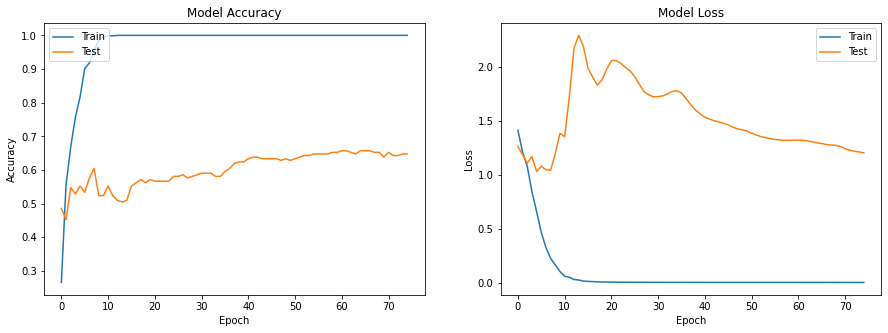

In [13]:
plot_metrics(acc_fold.mean(axis = 0), val_acc_fold.mean(axis = 0), loss_fold.mean(axis = 0), val_loss_fold.mean(axis = 0))

Mostramos la matriz de confusión de la última iteración por pantalla.

In [16]:
conf_matrix = metrics.confusion_matrix(Y_val.argmax(axis = 1), model_cc.predict(X_val).argmax(axis = 1))
print_cm(conf_matrix, list(dict_valores.keys()))

                benigno   control actuación   maligno 
      benigno       4.0       0.0       0.0       0.0 
      control       2.0       2.0       0.0       0.0 
    actuación       4.0       0.0       2.0       0.0 
      maligno       1.0       0.0       0.0       0.0 


Mostramos las métricas de resultados según categoría para poder evaluar el desempeño de la red en cada caso.

In [17]:
classif_report = metrics.classification_report(Y_val.argmax(axis = 1), model_cc.predict(X_val).argmax(axis = 1), 
                                               target_names = list(dict_valores.keys()))
print(classif_report)

              precision    recall  f1-score   support

     benigno       0.36      1.00      0.53         4
     control       1.00      0.50      0.67         4
   actuación       1.00      0.33      0.50         6
     maligno       0.00      0.00      0.00         1

    accuracy                           0.53        15
   macro avg       0.59      0.46      0.42        15
weighted avg       0.76      0.53      0.52        15



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Guardamos el modelo entrenado para su uso en pasos posteriores.

In [ ]:
# model_cc.save('cifar10.h5')